<a href="https://colab.research.google.com/github/anko00/MachineLearning/blob/main/Week_12_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7.5. Batch Normalization**

Source : https://d2l.ai/chapter_convolutional-modern/batch-norm.html


## 7.5.1. Training Deep Networks**

the math

## 7.5.2. Batch Normalization Layers**

Batch normalization implementations for fully-connected layers and convolutional layers are slightly different. We discuss both cases below. 

Recall that one key differences between batch normalization and other layers is that because** batch normalization operates on a full minibatch at a time**, we cannot just ignore the batch dimension as we did before when introducing other layers.


### 7.5.2.1. Fully-Connected Layers**

When applying batch normalization to fully-connected layers, the original paper inserts batch normalization after the affine transformation and before the nonlinear activation function (later applications may insert batch normalization right after activation functions) [Ioffe & Szegedy, 2015]. Denoting the input to the fully-connected layer by  x , the affine transformation by  Wx+b  (with the weight parameter  W  and the bias parameter  b ), and the activation function by  ϕ , we can express the computation of a batch-normalization-enabled, fully-connected layer output  h  as follows:

(7.5.3)
h=ϕ(BN(Wx+b)).
 
Recall that mean and variance are computed on the same minibatch on which the transformation is applied.

### 7.5.2.2. Convolutional Layers**

Similarly, with convolutional layers, we can apply batch normalization after the convolution and before the nonlinear activation function. 

When the convolution has multiple output channels, we need to carry out batch normalization for each of the outputs of these channels, and each channel has its own scale and shift parameters, both of which are scalars. 

Assume that our minibatches contain  m  examples and that for each channel, the output of the convolution has height  p  and width  q . For convolutional layers, we carry out each batch normalization over the  m⋅p⋅q  elements per output channel simultaneously. 

Thus, we collect the values over all spatial locations when computing the mean and variance and consequently apply the same mean and variance within a given channel to normalize the value at each spatial location.

### 7.5.2.3. Batch Normalization During Prediction**

As we mentioned earlier, batch normalization typically behaves differently in training mode and prediction (test) mode. First, the noise in the sample mean and the sample variance arising from estimating each on minibatches are no longer desirable once we have trained the model. Second, we might not have the luxury of computing per-batch normalization statistics. For example, we might need to apply our model to make one prediction at a time.

Typically, after training, we use the entire dataset to compute stable estimates of the variable statistics and then fix them at prediction time. **Consequently, batch normalization behaves differently during training and at test time**. Recall that dropout also exhibits this characteristic.

## 7.5.3. Implementation from Scratch**

Below, we implement a batch normalization layer with tensors from scratch.

We can now create a proper BatchNorm layer. Our layer will maintain proper parameters for scale gamma and shift beta, both of which will be updated in the course of training. Additionally, our layer will maintain moving averages of the means and variances for subsequent use during model prediction.



In [1]:
!pip install d2l==0.17.0

     |████████████████████████████████| 83 kB 1.2 MB/s 


In [2]:
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `is_grad_enabled` to determine whether the current mode is training
    # mode or prediction mode
    if not torch.is_grad_enabled():
        # If it is prediction mode, directly use the mean and variance
        # obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully-connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

We can now create a proper BatchNorm layer. Our layer will maintain proper parameters for scale gamma and shift beta, both of which will be updated in the course of training. Additionally, our layer will maintain moving averages of the means and variances for subsequent use during model prediction.

In [3]:
class BatchNorm(nn.Module):
    # `num_features`: the number of outputs for a fully-connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully-connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

**7.5.4. Applying Batch Normalization in LeNet**

To see how to apply BatchNorm in context, below we apply it to a traditional LeNet model (Section 6.6). Recall that batch normalization is applied after the convolutional layers or fully-connected layers but before the corresponding activation functions.

In [4]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), 
    BatchNorm(6, num_dims=4), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), 
    BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), 
    nn.Flatten(),
    nn.Linear(16*4*4, 120), 
    BatchNorm(120, num_dims=2), 
    nn.Sigmoid(),
    nn.Linear(120, 84), 
    BatchNorm(84, num_dims=2), 
    nn.Sigmoid(),
    nn.Linear(84, 10))

As before, we will train our network on the Fashion-MNIST dataset. This code is virtually identical to that when we first trained LeNet (Section 6.6). The main difference is the larger learning rate.

loss 0.270, train acc 0.901, test acc 0.863
2691.4 examples/sec on cpu


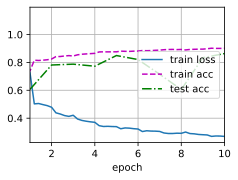

In [5]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Let us have a look at the scale parameter gamma and the shift parameter beta learned from the first batch normalization layer.

In [6]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([3.6002, 2.8404, 1.8831, 0.3973, 4.2793, 3.5329],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-1.3082, -0.3967,  2.0495,  0.6537,  2.2818, -3.6604],
        grad_fn=<ReshapeAliasBackward0>))

**7.5.5. Concise Implementation**

Compared with the BatchNorm class, which we just defined ourselves, we can use the BatchNorm class defined in high-level APIs from the deep learning framework directly. The code looks virtually identical to our implementation above.

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), 
    nn.BatchNorm2d(6), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), 
    nn.BatchNorm2d(16), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), 
    nn.Flatten(),
    nn.Linear(256, 120), 
    nn.BatchNorm1d(120), 
    nn.Sigmoid(),
    nn.Linear(120, 84), 
    nn.BatchNorm1d(84), 
    nn.Sigmoid(),
    nn.Linear(84, 10))

Below, we use the same hyperparameters to train our model. Note that as usual, the high-level API variant runs much faster because its code has been compiled to C++ or CUDA while our custom implementation must be interpreted by Python.

loss 0.263, train acc 0.903, test acc 0.831
3820.6 examples/sec on cpu


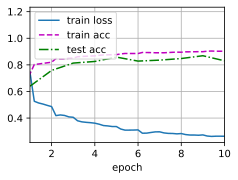

In [8]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**7.5.7. Summary**

During model training, batch normalization continuously adjusts the intermediate output of the neural network by utilizing the mean and standard deviation of the minibatch, so that the values of the intermediate output in each layer throughout the neural network are more stable.

The batch normalization methods for fully-connected layers and convolutional layers are slightly different.

Like a dropout layer, batch normalization layers have different computation results in training mode and prediction mode.

Batch normalization has many beneficial side effects, primarily that of regularization. On the other hand, the original motivation of reducing internal covariate shift seems not to be a valid explanation.

# 7.6. Residual Networks (ResNet)**

Theory : https://d2l.ai/chapter_convolutional-modern/resnet.html

Code : https://github.com/d2l-ai/d2l-en/blob/master/chapter_convolutional-modern/resnet.md

**7.6.1. Function Classes**

**7.6.2. Residual Blocks**

In [ ]:
!pip install d2l==0.17.0

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

Now let us look at a situation where the input and output are of the same shape.

In [ ]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

We also have the option to halve the output height and width while increasing the number of output channels.

In [ ]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

**7.6.3. ResNet Model**

The first two layers of ResNet are the same as those of the GoogLeNet we described before: the  7×7  convolutional layer with 64 output channels and a stride of 2 is followed by the  3×3  maximum pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in ResNet.

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet uses four modules made up of Inception blocks. However, ResNet uses four modules made up of residual blocks, each of which ** uses several residual blocks with the same number of output channels**. The number of channels in the first module is the same as the number of input channels. 

Since a maximum pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.

Now, we implement this module. Note that special processing has been performed on the first module.

In [ ]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

Then, we add all the modules to ResNet. Here, two residual blocks are used for each module

In [ ]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

Finally, just like GoogLeNet, we add a global average pooling layer, followed by the fully-connected layer output.

In [ ]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

Before training ResNet, let us observe how the input shape changes across different modules in ResNet. As in all the previous architectures, the resolution decreases while the number of channels increases up until the point where a global average pooling layer aggregates all features.

In [ ]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


**7.6.4. Training**
We train ResNet on the Fashion-MNIST dataset, just like before.

loss 0.016, train acc 0.996, test acc 0.921
597.0 examples/sec on cuda:0


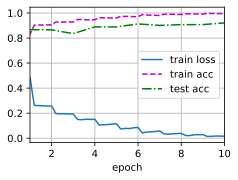

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**7.6.5. Summary**

Nested function classes are desirable. Learning an additional layer in deep neural networks as an identity function (though this is an extreme case) should be made easy.

The residual mapping can learn the identity function more easily, such as pushing parameters in the weight layer to zero.

We can train an effective deep neural network by having residual blocks. Inputs can forward propagate faster through the residual connections across layers.

ResNet had a major influence on the design of subsequent deep neural networks, both for convolutional and sequential nature.

#7.7 Modern CNN - AlexNet

theory : https://d2l.ai/chapter_convolutional-modern/densenet.html#
Source : https://github.com/d2l-ai/d2l-en/blob/master/chapter_convolutional-modern/densenet.md

In [ ]:
!pip install d2l==0.17.0

As shown in Fig. 7.7.1, the key difference between ResNet and DenseNet is that in the latter case outputs are **concatenated** (denoted by  [,] ) rather than added. 

As a result, we perform a mapping from  x  to its values after applying an increasingly complex sequence of functions:

x→[x,f1(x),f2([x,f1(x)]),f3([x,f1(x),f2([x,f1(x)])]),…].
 
In the end, all these functions are combined in MLP to reduce the number of features again. In terms of implementation this is quite simple: rather than adding terms, we concatenate them. The name DenseNet arises from the fact that the dependency graph between variables becomes quite dense. The last layer of such a chain is densely connected to all previous layers

7.7.2. Dense Blocks

DenseNet uses the modified “batch normalization, activation, and convolution” structure of ResNet (see the exercise in Section 7.6). First, we implement this convolution block structure.

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l


def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

In the following example, we define a DenseBlock instance with 2 convolution blocks of 10 output channels. 

When using an input with 3 channels, we will get an output with  3+2×10=23  channels. The number of convolution block channels controls the growth in the number of output channels relative to the number of input channels. This is also referred to as the growth rate.

In [ ]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

**7.7.3. Transition Layers**

Since each dense block will increase the number of channels, adding too many of them will lead to an excessively complex model. A transition layer is used **to control the complexity of the model**. It reduces the number of channels by using the  1×1  convolutional layer and halves the height and width of the average pooling layer with a stride of 2, further reducing the complexity of the model.

In [ ]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

Apply a transition layer with 10 channels to the output of the dense block in the previous example. This reduces the number of output channels to 10, and halves the height and width.

In [ ]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

**7.7.4. DenseNet Model**

Next, we will construct a DenseNet model. DenseNet first uses the same single convolutional layer and maximum pooling layer as in ResNet.

In [ ]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

Then, similar to the four modules made up of residual blocks that ResNet uses, DenseNet **uses four dense blocks**. Similar to ResNet, we can set the number of convolutional layers used in each dense block.  

Furthermore, we set the number of channels (i.e., growth rate) for the convolutional layers in the dense block to 32, so 128 channels will be added to each dense block.

In ResNet, the height and width are reduced between each module by a residual block with a stride of 2. Here, **we use the transition layer to halve the height and width and halve the number of channels.**

In [ ]:
# `num_channels`: the current number of channels
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that halves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

Similar to ResNet, a global pooling layer and a fully-connected layer are connected at the end to produce the output.

In [ ]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), 
    nn.ReLU(),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

**7.7.5. Training**

Since we are using a deeper network here, in this section, we will reduce the input height and width of the Fashion MNIST data from 224 to 96 to simplify the computation.

loss 0.145, train acc 0.947, test acc 0.901
794.9 examples/sec on cuda:0


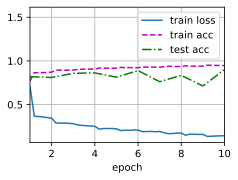

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**7.7.6. Summary**

In terms of cross-layer connections, unlike ResNet, where inputs and outputs are added together, **DenseNet concatenates inputs and outputs on the channel dimension.**

The main components that compose DenseNet are **dense blocks and transition layers.**

We need to keep the dimensionality under control when composing the network by adding transition layers that shrink the number of channels again.